# TP Estimation Statistique Avancée (Suite)

Dans cette partie du TP, nous allons explorer deux méthodes d'estimation par intervalle de confiance supplémentaires :
* Estimation par intervalle de confiance pour une proportion
* Estimation par intervalle de confiance pour une variance (moyenne connue et inconnue)

In [4]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(0)  # Pour la reproductibilité

## 1. Estimation par intervalle de confiance pour une proportion

Lorsque l'on veut estimer une proportion p dans une population, on utilise généralement la statistique $\hat{p} = \frac{X}{n}$ où X est le nombre de succès dans un échantillon de taille n. Sous certaines conditions (n assez grand), cette statistique suit approximativement une loi normale.

In [5]:
# Génération d'un échantillon binomial (succès/échec)
p_true = 0.3  # Proportion réelle
taille_echantillon = 100
echantillon_bin = np.random.binomial(1, p_true, size=taille_echantillon)

# Estimation de la proportion
p_hat = np.mean(echantillon_bin)

print(f"Proportion réelle : {p_true}")
print(f"Proportion estimée : {p_hat}")
print(f"Nombre de succès : {int(p_hat * taille_echantillon)}")

Proportion réelle : 0.3
Proportion estimée : 0.23
Nombre de succès : 23


### 1.1 Intervalle de confiance avec l'approximation normale

Pour n assez grand (généralement n*p ≥ 5 et n*(1-p) ≥ 5), on peut utiliser l'approximation normale. L'erreur standard de $\hat{p}$ est donnée par $\sqrt{\frac{p(1-p)}{n}}$.

In [6]:
# Niveau de confiance
alpha = 0.05  # 95% de confiance
z_alpha_2 = stats.norm.ppf(1 - alpha/2)  # Quantile de la loi normale centrée réduite

# Erreur standard estimée
erreur_standard = np.sqrt(p_hat * (1 - p_hat) / taille_echantillon)

# Intervalle de confiance
ic_inf = p_hat - z_alpha_2 * erreur_standard
ic_sup = p_hat + z_alpha_2 * erreur_standard

print(f"Proportion réelle : {p_true}")
print(f"Proportion estimée : {p_hat:.4f}")
print(f"Intervalle de confiance à 95% : [{max(0, ic_inf):.4f}, {min(1, ic_sup):.4f}]")
print(f"Largeur de l'intervalle : {ic_sup - ic_inf:.4f}")
print(f"La proportion réelle est dans l'intervalle : {ic_inf <= p_true <= ic_sup}")

Proportion réelle : 0.3
Proportion estimée : 0.2300
Intervalle de confiance à 95% : [0.1475, 0.3125]
Largeur de l'intervalle : 0.1650
La proportion réelle est dans l'intervalle : True


Visualisons l'intervalle de confiance :

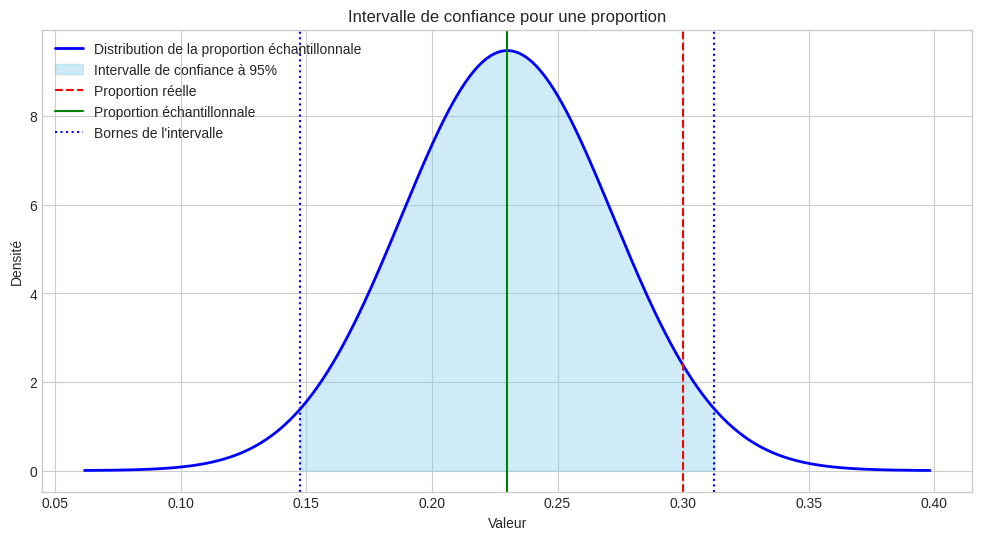

In [7]:
plt.figure(figsize=(12, 6))

# Densité de la loi normale de la proportion échantillonnale
x = np.linspace(max(0, p_hat - 4*erreur_standard), min(1, p_hat + 4*erreur_standard), 1000)
y = stats.norm.pdf(x, p_hat, erreur_standard)

plt.plot(x, y, 'b-', linewidth=2, label='Distribution de la proportion échantillonnale')

# Coloration de l'intervalle de confiance
x_ic = np.linspace(max(0, ic_inf), min(1, ic_sup), 100)
y_ic = stats.norm.pdf(x_ic, p_hat, erreur_standard)
plt.fill_between(x_ic, y_ic, color='skyblue', alpha=0.4, label='Intervalle de confiance à 95%')

# Ajout des lignes verticales
plt.axvline(x=p_true, color='r', linestyle='--', label='Proportion réelle')
plt.axvline(x=p_hat, color='g', linestyle='-', label='Proportion échantillonnale')
plt.axvline(x=max(0, ic_inf), color='b', linestyle=':', label='Bornes de l\'intervalle')
plt.axvline(x=min(1, ic_sup), color='b', linestyle=':')

plt.title('Intervalle de confiance pour une proportion')
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.legend()
plt.grid(True)
plt.show()

### 1.2 Correction de continuité (Intervalle de Wilson)

L'intervalle de Wilson est une méthode plus précise pour estimer l'intervalle de confiance d'une proportion, notamment pour les petits échantillons ou les proportions proches de 0 ou 1.

In [ ]:
# Calcul de l'intervalle de Wilson
# Nombre de succès
X = int(p_hat * taille_echantillon)

# Terme central
centre = (X + z_alpha_2**2/2) / (taille_echantillon + z_alpha_2**2)

# Terme de marge
marge = z_alpha_2 * np.sqrt((X * (taille_echantillon - X) / taille_echantillon + z_alpha_2**2/4) / 
                      (taille_echantillon + z_alpha_2**2))

# Limites de l'intervalle
ic_inf_wilson = max(0, centre - marge)
ic_sup_wilson = min(1, centre + marge)

print(f"Proportion réelle : {p_true}")
print(f"Proportion estimée : {p_hat:.4f}")
print(f"Intervalle de confiance normal à 95% : [{max(0, ic_inf):.4f}, {min(1, ic_sup):.4f}]")
print(f"Intervalle de Wilson à 95% : [{ic_inf_wilson:.4f}, {ic_sup_wilson:.4f}]")
print(f"La proportion réelle est dans l'intervalle normal : {ic_inf <= p_true <= ic_sup}")
print(f"La proportion réelle est dans l'intervalle de Wilson : {ic_inf_wilson <= p_true <= ic_sup_wilson}")

Comparons les deux méthodes pour différentes tailles d'échantillon :

In [ ]:
# Différentes tailles d'échantillon
tailles = [10, 20, 30, 50, 100, 200, 500, 1000]
largeurs_norm = []
largeurs_wilson = []
couverture_norm = []
couverture_wilson = []

n_simulations = 1000  # Nombre de simulations pour chaque taille

for n in tailles:
    compteur_norm = 0
    compteur_wilson = 0
    largeur_norm_total = 0
    largeur_wilson_total = 0
    
    for _ in range(n_simulations):
        # Génération d'un échantillon
        echantillon = np.random.binomial(1, p_true, size=n)
        p_est = np.mean(echantillon)
        X = int(p_est * n)
        
        # Méthode normale
        err_std = np.sqrt(p_est * (1 - p_est) / n)
        ic_inf_n = max(0, p_est - z_alpha_2 * err_std)
        ic_sup_n = min(1, p_est + z_alpha_2 * err_std)
        
        # Méthode de Wilson
        centre = (X + z_alpha_2**2/2) / (n + z_alpha_2**2)
        marge = z_alpha_2 * np.sqrt((X * (n - X) / n + z_alpha_2**2/4) / (n + z_alpha_2**2))
        ic_inf_w = max(0, centre - marge)
        ic_sup_w = min(1, centre + marge)
        
        # Vérification de la couverture
        if ic_inf_n <= p_true <= ic_sup_n:
            compteur_norm += 1
        if ic_inf_w <= p_true <= ic_sup_w:
            compteur_wilson += 1
            
        # Calcul des largeurs
        largeur_norm_total += (ic_sup_n - ic_inf_n)
        largeur_wilson_total += (ic_sup_w - ic_inf_w)
    
    # Moyenne des résultats
    couverture_norm.append(compteur_norm / n_simulations)
    couverture_wilson.append(compteur_wilson / n_simulations)
    largeurs_norm.append(largeur_norm_total / n_simulations)
    largeurs_wilson.append(largeur_wilson_total / n_simulations)

# Visualisation des résultats
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Taux de couverture
ax1.plot(tailles, couverture_norm, 'bo-', linewidth=2, label='Méthode normale')
ax1.plot(tailles, couverture_wilson, 'ro-', linewidth=2, label='Méthode de Wilson')
ax1.axhline(y=1-alpha, color='k', linestyle='--', label='Niveau nominal (95%)')
ax1.set_title('Taux de couverture des intervalles de confiance')
ax1.set_xlabel('Taille de l\'échantillon')
ax1.set_ylabel('Taux de couverture')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True)

# Largeur des intervalles
ax2.plot(tailles, largeurs_norm, 'bo-', linewidth=2, label='Méthode normale')
ax2.plot(tailles, largeurs_wilson, 'ro-', linewidth=2, label='Méthode de Wilson')
ax2.set_title('Largeur moyenne des intervalles de confiance')
ax2.set_xlabel('Taille de l\'échantillon')
ax2.set_ylabel('Largeur moyenne')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 2. Estimation par intervalle de confiance pour la variance d'une loi normale

L'estimation de la variance $\sigma^2$ d'une loi normale repose sur la propriété suivante : si $X_1, X_2, ..., X_n$ est un échantillon aléatoire d'une distribution normale de moyenne $\mu$ et de variance $\sigma^2$, alors la statistique $\frac{(n-1)S^2}{\sigma^2}$ suit une loi du $\chi^2$ à $(n-1)$ degrés de liberté, où $S^2$ est la variance échantillonnale non biaisée.

### 2.1 Intervalle de confiance pour la variance (moyenne connue)

Lorsque la moyenne $\mu$ est connue, la statistique $\frac{\sum_{i=1}^{n}(X_i - \mu)^2}{\sigma^2}$ suit une loi du $\chi^2$ à $n$ degrés de liberté.

In [8]:
# Génération d'un échantillon suivant une loi normale
mu_true = 10
sigma_true = 2
taille_echantillon = 50
echantillon = np.random.normal(loc=mu_true, scale=sigma_true, size=taille_echantillon)

# Calcul de la variance biaisée (avec mu connu)
variance_biaisee_mu_connu = np.sum((echantillon - mu_true)**2) / taille_echantillon

# Niveau de confiance
alpha = 0.05  # 95% de confiance

# Quantiles de la loi du chi-2 à n degrés de liberté
chi2_inf = stats.chi2.ppf(alpha/2, df=taille_echantillon)
chi2_sup = stats.chi2.ppf(1 - alpha/2, df=taille_echantillon)

# Intervalle de confiance pour sigma²
ic_inf_var = taille_echantillon * variance_biaisee_mu_connu / chi2_sup
ic_sup_var = taille_echantillon * variance_biaisee_mu_connu / chi2_inf

# Intervalle de confiance pour sigma
ic_inf_sigma = np.sqrt(ic_inf_var)
ic_sup_sigma = np.sqrt(ic_sup_var)

print(f"Variance réelle : {sigma_true**2}")
print(f"Variance estimée (moyenne connue) : {variance_biaisee_mu_connu:.4f}")
print(f"Intervalle de confiance à 95% pour la variance : [{ic_inf_var:.4f}, {ic_sup_var:.4f}]")
print(f"Écart-type réel : {sigma_true}")
print(f"Intervalle de confiance à 95% pour l'écart-type : [{ic_inf_sigma:.4f}, {ic_sup_sigma:.4f}]")
print(f"La variance réelle est dans l'intervalle : {ic_inf_var <= sigma_true**2 <= ic_sup_var}")

Variance réelle : 4
Variance estimée (moyenne connue) : 4.8053
Intervalle de confiance à 95% pour la variance : [3.3641, 7.4254]
Écart-type réel : 2
Intervalle de confiance à 95% pour l'écart-type : [1.8342, 2.7250]
La variance réelle est dans l'intervalle : True


Visualisons l'intervalle de confiance pour la variance :

<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:32: SyntaxWarning: invalid escape sequence '\c'
<>:33: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_82807/4168021413.py:11: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(x, y, 'b-', linewidth=2, label='Distribution du $\chi^2$')
/tmp/ipykernel_82807/4168021413.py:32: SyntaxWarning: invalid escape sequence '\c'
  plt.title('Distribution du $\chi^2$ pour l\'intervalle de confiance de la variance (moyenne connue)')
/tmp/ipykernel_82807/4168021413.py:33: SyntaxWarning: invalid escape sequence '\h'
  plt.xlabel('Valeur de la statistique $\\frac{n\hat{\sigma}^2}{\sigma^2}$')


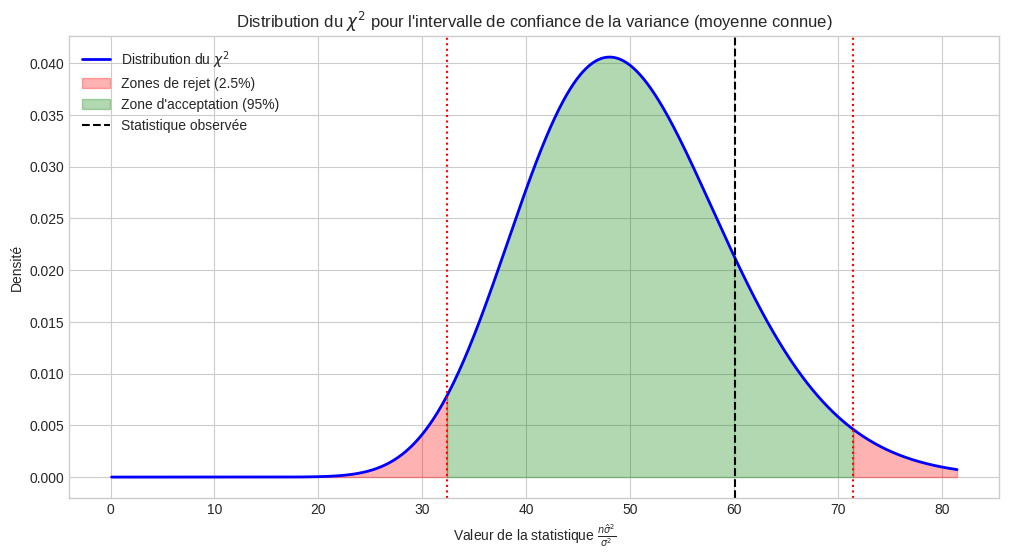

In [9]:
# Suppress warnings about invalid escape sequences
import warnings

plt.figure(figsize=(12, 6))

# Densité de la loi du chi-2 pour la variance
x = np.linspace(0.1, chi2_sup + 10, 1000)
stat = taille_echantillon * variance_biaisee_mu_connu / sigma_true**2
y = stats.chi2.pdf(x, df=taille_echantillon)

plt.plot(x, y, 'b-', linewidth=2, label='Distribution du $\chi^2$')

# Coloration des zones de rejet
x_reject_left = np.linspace(0.1, chi2_inf, 100)
y_reject_left = stats.chi2.pdf(x_reject_left, df=taille_echantillon)
plt.fill_between(x_reject_left, y_reject_left, color='red', alpha=0.3, label='Zones de rejet (2.5%)')

x_reject_right = np.linspace(chi2_sup, chi2_sup + 10, 100)
y_reject_right = stats.chi2.pdf(x_reject_right, df=taille_echantillon)
plt.fill_between(x_reject_right, y_reject_right, color='red', alpha=0.3)

# Zone d'acceptation
x_accept = np.linspace(chi2_inf, chi2_sup, 100)
y_accept = stats.chi2.pdf(x_accept, df=taille_echantillon)
plt.fill_between(x_accept, y_accept, color='green', alpha=0.3, label='Zone d\'acceptation (95%)')

# Statistique observée
plt.axvline(x=stat, color='k', linestyle='--', label='Statistique observée')
plt.axvline(x=chi2_inf, color='r', linestyle=':')
plt.axvline(x=chi2_sup, color='r', linestyle=':')

plt.title('Distribution du $\chi^2$ pour l\'intervalle de confiance de la variance (moyenne connue)')
plt.xlabel('Valeur de la statistique $\\frac{n\hat{\sigma}^2}{\sigma^2}$')
plt.ylabel('Densité')
plt.legend()
plt.grid(True)

# ignore SyntaxWarning
warnings.filterwarnings("ignore", category=SyntaxWarning, message="invalid escape sequence.*")

plt.show()

### 2.2 Intervalle de confiance pour la variance (moyenne inconnue)

Lorsque la moyenne $\mu$ est inconnue et doit être estimée, on utilise la variance échantillonnale $S^2 = \frac{1}{n-1}\sum_{i=1}^{n}(X_i - \bar{X})^2$ et la statistique $\frac{(n-1)S^2}{\sigma^2}$ qui suit une loi du $\chi^2$ à $(n-1)$ degrés de liberté.

In [10]:
# Calcul de la variance non biaisée (avec mu inconnu)
variance_non_biaisee = np.var(echantillon, ddof=1)  # ddof=1 pour utiliser n-1 au dénominateur

# Quantiles de la loi du chi-2 à (n-1) degrés de liberté
chi2_inf_n1 = stats.chi2.ppf(alpha/2, df=taille_echantillon-1)
chi2_sup_n1 = stats.chi2.ppf(1 - alpha/2, df=taille_echantillon-1)

# Intervalle de confiance pour sigma²
ic_inf_var_n1 = (taille_echantillon - 1) * variance_non_biaisee / chi2_sup_n1
ic_sup_var_n1 = (taille_echantillon - 1) * variance_non_biaisee / chi2_inf_n1

# Intervalle de confiance pour sigma
ic_inf_sigma_n1 = np.sqrt(ic_inf_var_n1)
ic_sup_sigma_n1 = np.sqrt(ic_sup_var_n1)

print(f"Variance réelle : {sigma_true**2}")
print(f"Variance estimée (moyenne connue) : {variance_biaisee_mu_connu:.4f}")
print(f"Variance estimée (moyenne inconnue) : {variance_non_biaisee:.4f}")
print(f"Intervalle de confiance à 95% pour la variance (moyenne connue) : [{ic_inf_var:.4f}, {ic_sup_var:.4f}]")
print(f"Intervalle de confiance à 95% pour la variance (moyenne inconnue) : [{ic_inf_var_n1:.4f}, {ic_sup_var_n1:.4f}]")
print(f"Écart-type réel : {sigma_true}")
print(f"Intervalle de confiance à 95% pour l'écart-type (moyenne inconnue) : [{ic_inf_sigma_n1:.4f}, {ic_sup_sigma_n1:.4f}]")
print(f"La variance réelle est dans l'intervalle (moyenne connue) : {ic_inf_var <= sigma_true**2 <= ic_sup_var}")
print(f"La variance réelle est dans l'intervalle (moyenne inconnue) : {ic_inf_var_n1 <= sigma_true**2 <= ic_sup_var_n1}")

Variance réelle : 4
Variance estimée (moyenne connue) : 4.8053
Variance estimée (moyenne inconnue) : 4.1897
Intervalle de confiance à 95% pour la variance (moyenne connue) : [3.3641, 7.4254]
Intervalle de confiance à 95% pour la variance (moyenne inconnue) : [2.9235, 6.5060]
Écart-type réel : 2
Intervalle de confiance à 95% pour l'écart-type (moyenne inconnue) : [1.7098, 2.5507]
La variance réelle est dans l'intervalle (moyenne connue) : True
La variance réelle est dans l'intervalle (moyenne inconnue) : True


Comparons les intervalles de confiance pour la variance avec moyenne connue et inconnue :

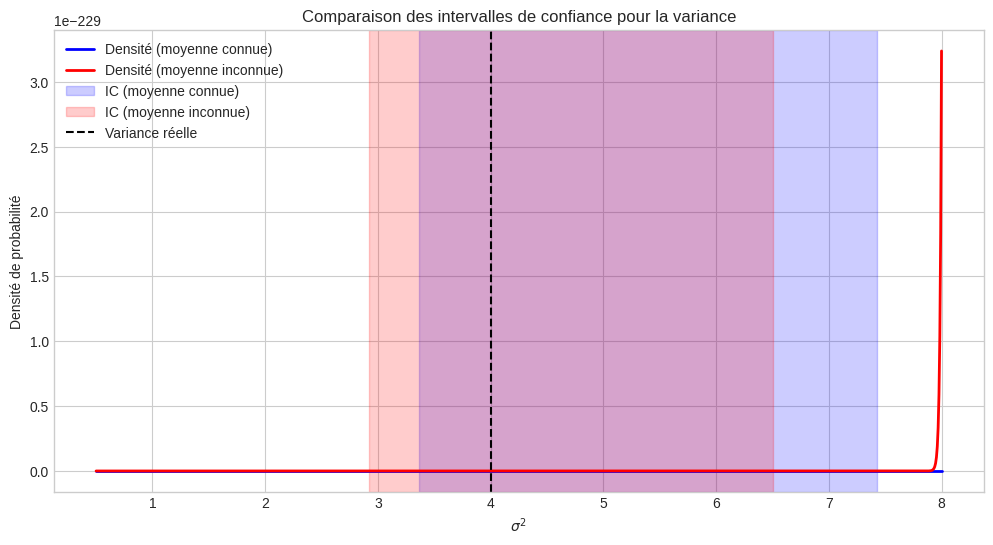

In [11]:
# Visualisation des deux intervalles de confiance pour la variance
plt.figure(figsize=(12, 6))

# Création d'une grille de valeurs pour sigma²
sigma2_range = np.linspace(0.5, 8, 1000)

# Fonction de densité de probabilité pour S² (moyenne connue)
def pdf_var_mu_connu(sigma2):
    # Transformation de variable
    # Si X ~ chi2(n), alors Y = aX suit une loi gamma
    return stats.gamma.pdf(variance_biaisee_mu_connu * taille_echantillon / sigma2, 
                           a=taille_echantillon/2, scale=2/taille_echantillon) * (variance_biaisee_mu_connu * taille_echantillon / sigma2**2)

# Fonction de densité de probabilité pour S² (moyenne inconnue)
def pdf_var_mu_inconnu(sigma2):
    return stats.gamma.pdf(variance_non_biaisee * (taille_echantillon-1) / sigma2, 
                           a=(taille_echantillon-1)/2, scale=2/(taille_echantillon-1)) * (variance_non_biaisee * (taille_echantillon-1) / sigma2**2)

# Calcul des densités
y_connu = [pdf_var_mu_connu(s2) for s2 in sigma2_range]
y_inconnu = [pdf_var_mu_inconnu(s2) for s2 in sigma2_range]

# Tracé des densités
plt.plot(sigma2_range, y_connu, 'b-', linewidth=2, label='Densité (moyenne connue)')
plt.plot(sigma2_range, y_inconnu, 'r-', linewidth=2, label='Densité (moyenne inconnue)')

# Coloration des intervalles de confiance
plt.axvspan(ic_inf_var, ic_sup_var, alpha=0.2, color='blue', label='IC (moyenne connue)')
plt.axvspan(ic_inf_var_n1, ic_sup_var_n1, alpha=0.2, color='red', label='IC (moyenne inconnue)')

# Ligne verticale pour la vraie valeur
plt.axvline(x=sigma_true**2, color='k', linestyle='--', label='Variance réelle')

plt.title('Comparaison des intervalles de confiance pour la variance')
plt.xlabel('$\sigma^2$')
plt.ylabel('Densité de probabilité')
plt.legend()
plt.grid(True)
plt.show()

Étudions l'impact de la taille de l'échantillon sur la largeur des intervalles de confiance :

In [ ]:
# Différentes tailles d'échantillon
tailles = [10, 20, 30, 50, 100, 200, 500, 1000]
largeurs_mu_connu = []
largeurs_mu_inconnu = []
couverture_mu_connu = []
couverture_mu_inconnu = []

n_simulations = 1000  # Nombre de simulations pour chaque taille

for n in tailles:
    compteur_mu_connu = 0
    compteur_mu_inconnu = 0
    largeur_mu_connu_total = 0
    largeur_mu_inconnu_total = 0
    
    for _ in range(n_simulations):
        # Génération d'un échantillon
        echantillon = np.random.normal(loc=mu_true, scale=sigma_true, size=n)
        
        # Variance biaisée (mu connu)
        variance_biaisee = np.sum((echantillon - mu_true)**2) / n
        
        # Variance non biaisée (mu inconnu)
        variance_non_biaisee = np.var(echantillon, ddof=1)
        
        # Intervalle de confiance (moyenne connue)
        ic_inf_var = n * variance_biaisee / chi2_sup
        ic_sup_var = n * variance_biaisee / chi2_inf
        
        # Intervalle de confiance (moyenne inconnue)
        ic_inf_var_n1 = (n - 1) * variance_non_biaisee / chi2_sup_n1
        ic_sup_var_n1 = (n - 1) * variance_non_biaisee / chi2_inf_n1
        
        # Vérification de la couverture
        if ic_inf_var <= sigma_true**2 <= ic_sup_var:
            compteur_mu_connu += 1
        if ic_inf_var_n1 <= sigma_true**2 <= ic_sup_var_n1:
            compteur_mu_inconnu += 1
            
        # Calcul des largeurs
        largeur_mu_connu_total += (ic_sup_var - ic_inf_var)
        largeur_mu_inconnu_total += (ic_sup_var_n1 - ic_inf_var_n1)
    
    # Moyenne des résultats
    couverture_mu_connu.append(compteur_mu_connu / n_simulations)
    couverture_mu_inconnu.append(compteur_mu_inconnu / n_simulations)
    largeurs_mu_connu.append(largeur_mu_connu_total / n_simulations)
    largeurs_mu_inconnu.append(largeur_mu_inconnu_total / n_simulations)

# Visualisation des résultats
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Taux de couverture
ax1.plot(tailles, couverture_mu_connu, 'bo-', linewidth=2, label='Moyenne connue')
ax1.plot(tailles, couverture_mu_inconnu, 'ro-', linewidth=2, label='Moyenne incounue')
ax1.axhline(y=1-alpha, color='k', linestyle='--', label='Niveau nominal (95%)')
ax1.set_title('Taux de couverture des intervalles de confiance pour la variance')
ax1.set_xlabel('Taille de l\'échantillon')
ax1.set_ylabel('Taux de couverture')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True)

# Largeur des intervalles
ax2.plot(tailles, largeurs_mu_connu, 'bo-', linewidth=2, label='Moyenne connue')
ax2.plot(tailles, largeurs_mu_inconnu, 'ro-', linewidth=2, label='Moyenne incounue')
ax2.set_title('Largeur moyenne des intervalles de confiance pour la variance')
ax2.set_xlabel('Taille de l\'échantillon')
ax2.set_ylabel('Largeur moyenne')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()